# LightGBM model

### Read data

In [129]:
#import lightgbm as lgbm
from scipy import sparse as ssp
from sklearn.model_selection import StratifiedKFold
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

In [102]:
path = "./data/"

train = pd.read_csv(path+'train.csv')
train_label = train['target']
train_id = train['id']
test = pd.read_csv(path+'test.csv')
test_id = test['id']

In [15]:
train

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595207,1488013,0,3,1,10,0,0,0,0,0,...,4,1,9,6,0,1,1,0,1,1
595208,1488016,0,5,1,3,0,0,0,0,0,...,4,1,3,8,1,0,1,0,1,1
595209,1488017,0,1,1,10,0,0,1,0,0,...,3,2,2,6,0,0,1,0,0,0
595210,1488021,0,5,2,3,1,0,0,0,1,...,4,1,4,2,0,1,1,1,0,0


In [8]:
train_label.value_counts()/train_label.count()

0    0.963552
1    0.036448
Name: target, dtype: float64

## Feature engineer
* Loại bỏ tất cả đặc trưng `calc`
* Thêm đặc trưng: Số lượng giá trị thiếu mỗi dòng
* Mã hóa one hot với các đặc trưng `cat`
* Gộp các đặc trưng `ind` làm một: `new_ind`
* Đếm các đặc trưng `cat` kể cả `new_ind`

### Prepare

In [105]:
y = train['target'].values
drop_feature = [
    'id',
    'target'
]

X = train.drop(drop_feature,axis=1)
feature_names = X.columns.tolist()
cat_features = [c for c in feature_names if ('cat' in c and 'count' not in c)]
num_features = [c for c in feature_names if ('cat' not in c and 'calc' not in c)]

In [106]:
X.columns.sort_values()

Index(['ps_calc_01', 'ps_calc_02', 'ps_calc_03', 'ps_calc_04', 'ps_calc_05',
       'ps_calc_06', 'ps_calc_07', 'ps_calc_08', 'ps_calc_09', 'ps_calc_10',
       'ps_calc_11', 'ps_calc_12', 'ps_calc_13', 'ps_calc_14',
       'ps_calc_15_bin', 'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin',
       'ps_calc_19_bin', 'ps_calc_20_bin', 'ps_car_01_cat', 'ps_car_02_cat',
       'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat', 'ps_car_06_cat',
       'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat',
       'ps_car_11', 'ps_car_11_cat', 'ps_car_12', 'ps_car_13', 'ps_car_14',
       'ps_car_15', 'ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03', 'ps_ind_04_cat',
       'ps_ind_05_cat', 'ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin',
       'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin',
       'ps_ind_13_bin', 'ps_ind_14', 'ps_ind_15', 'ps_ind_16_bin',
       'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_reg_01', 'ps_reg_02',
       'ps_reg_03'],
      dtype='obj

In [107]:
X.columns.str.split("_").str[1].value_counts()

calc    20
ind     18
car     16
reg      3
dtype: int64

In [133]:
corr = train.drop("id",axis=1).corr()

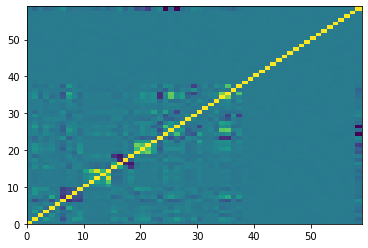

In [143]:
plt.pcolor(corr)

### Số lượng giá trị thiếu mỗi dòng

In [112]:
train['missing'] = (train==-1).sum(axis=1).astype(float)
test['missing'] = (test==-1).sum(axis=1).astype(float)
num_features.append('missing')

In [45]:
train["missing"].value_counts()

2.0    254982
1.0    156295
0.0    124931
3.0     56042
4.0      2883
7.0        53
6.0        19
8.0         7
Name: missing, dtype: int64

In [125]:
noise = 0.5 * np.random.rand(train.shape[0]) - 0.25
noise

array([ 0.05944265,  0.10946846,  0.09445202, ..., -0.12203207,
       -0.19346123,  0.09688167])

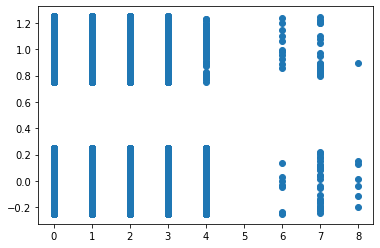

In [130]:
plt.scatter(train["missing"], train["target"]+noise)

In [131]:
train[["missing", "target"]].corr()

,missing,target
missing,1.00000,-0.02502
target,-0.02502,1.00000
